# Notebook 2 : Collaborative Filtering avec SVD

## Objectifs de ce notebook

Dans ce notebook, nous allons :

1. Comprendre le concept du Collaborative Filtering
2. Charger les données nettoyées du Notebook 1
3. Diviser les données en Train/Test
4. Implémenter SVD (Singular Value Decomposition)
5. Évaluer le modèle avec RMSE
6. Générer des recommandations pour un utilisateur
7. Comprendre les facteurs latents

---

## Qu'est-ce que le Collaborative Filtering ?

Le **Collaborative Filtering** (filtrage collaboratif) fait des prédictions basées sur les **comportements similaires** entre utilisateurs.

### Principe simple :
- Si l'utilisateur A et B ont aimé les mêmes films dans le passé
- Et que A a aimé un nouveau film
- Alors B aimera probablement ce film aussi

### Matrix Factorization (SVD) :
Au lieu de calculer directement les similarités, SVD décompose la matrice utilisateur-film en **facteurs latents**.

**Exemple de facteurs latents** :
- Facteur 1 : "Action vs Romance"
- Facteur 2 : "Classique vs Moderne"
- Facteur 3 : "Sérieux vs Comédie"

Chaque utilisateur et chaque film a un "score" sur ces facteurs cachés.

---

In [1]:
# Librairies pour manipulation de données
import pandas as pd
import numpy as np

# Librairies pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Surprise : librairie spécialisée pour les systèmes de recommandation
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Configuration des graphiques
plt.style.use('ggplot')
sns.set_palette('husl')
%matplotlib inline

# Affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Librairies importées avec succès!")

✅ Librairies importées avec succès!


## 2. Chargement des Données Nettoyées

Nous chargeons les données que nous avons préparées dans le **Notebook 1** :
- **ratings_clean.csv** : Les notes des utilisateurs
- **movies_clean.csv** : Les informations sur les films

Nous allons utiliser uniquement les colonnes nécessaires pour le Collaborative Filtering :
- `user_id` : ID de l'utilisateur
- `item_id` : ID du film
- `rating` : Note donnée (1 à 5)

In [2]:
ratings = pd.read_csv("../data/processed/ratings_clean.csv")
movies = pd.read_csv("../data/processed/movies_clean.csv")

print(ratings.head())
print(f'Total ratings : {len(ratings):,}')
print(f"le nombre des films : {ratings['item_id'].nunique()}")
print(f'le nombre des utilisateurs : {ratings["user_id"].nunique()}')

   user_id  item_id  rating  timestamp                 date  rating_year  \
0      196      242       3  881250949  1997-12-04 15:55:49         1997   
1      186      302       3  891717742  1998-04-04 19:22:22         1998   
2       22      377       1  878887116  1997-11-07 07:18:36         1997   
3      244       51       2  880606923  1997-11-27 05:02:03         1997   
4      166      346       1  886397596  1998-02-02 05:33:16         1998   

   rating_month  
0            12  
1             4  
2            11  
3            11  
4             2  
Total ratings : 100,000
le nombre des films : 1682
le nombre des utilisateurs : 943


In [3]:
print(ratings['rating'].value_counts().sort_values(ascending=False))
print(f"\n Note moyenne : {ratings['rating'].mean():.2f}")
print(f" Note médiane : {ratings['rating'].median():.2f}")

rating
4    34174
3    27145
5    21201
2    11370
1     6110
Name: count, dtype: int64

 Note moyenne : 3.53
 Note médiane : 4.00


## 3. Préparation des Données pour Surprise

La librairie Surprise a besoin d'un format spécifique pour travailler :

1. **Reader** : Indique l'échelle des notes (1 à 5 dans notre cas)
2. **Dataset** : Convertit notre DataFrame pandas en format Surprise
3. **Train/Test split** : Divise les données en 80% entraînement, 20% test

Pourquoi diviser les données ?
- Le Train set sert à apprendre les patterns
- Le Test set sert à évaluer si le modèle généralise bien

In [4]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df = ratings[['item_id' , 'user_id' , 'rating']] , reader=reader)


In [5]:
# Division des données : 80% train, 20% test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print(f"Train set : {trainset.n_ratings} ratings")
print(f"Test set : {len(testset)} ratings")
print(f"\nPourcentage train : {trainset.n_ratings / len(ratings) * 100:.1f}%")
print(f"Pourcentage test : {len(testset) / len(ratings) * 100:.1f}%")

Train set : 80000 ratings
Test set : 20000 ratings

Pourcentage train : 80.0%
Pourcentage test : 20.0%


In [6]:
ratings

,user_id,item_id,rating,timestamp,date,rating_year,rating_month
0,196,242,3,881250949,1997-12-04 15:55:49,1997,12
1,186,302,3,891717742,1998-04-04 19:22:22,1998,4
2,22,377,1,878887116,1997-11-07 07:18:36,1997,11
3,244,51,2,880606923,1997-11-27 05:02:03,1997,11
4,166,346,1,886397596,1998-02-02 05:33:16,1998,2
...,...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22 05:10:44,1997,11
99996,716,204,5,879795543,1997-11-17 19:39:03,1997,11
99997,276,1090,1,874795795,1997-09-20 22:49:55,1997,9
99998,13,225,2,882399156,1997-12-17 22:52:36,1997,12


In [7]:
user_item_matrix = ratings.pivot_table(
    values = 'rating',
    index = 'user_id',
    columns='item_id'
)

## calculons la sparsité :
total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
filled_cells = user_item_matrix.notna().sum().sum()
sparcity = 1 - filled_cells/total_cells

print(f"la sparsité est de {sparcity:0.2} %")


la sparsité est de 0.94 %


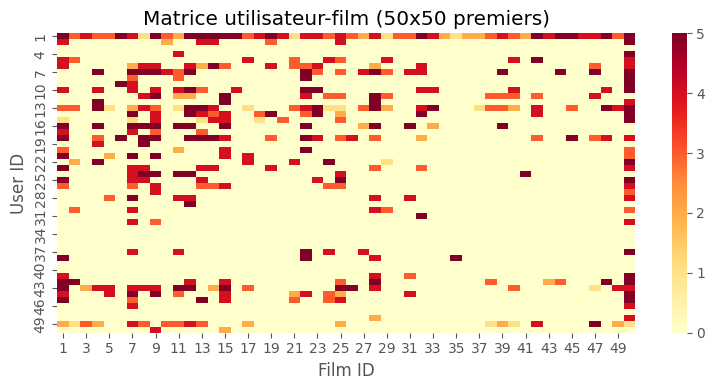

In [8]:
subset = user_item_matrix.iloc[:50, :50]
subset = subset.fillna(value=0)

plt.figure(figsize=(8,4))
sns.heatmap(subset , cmap = 'YlOrRd')
plt.title("Matrice utilisateur-film (50x50 premiers)")
plt.xlabel("Film ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

## 4. Entraînement du Modèle SVD

SVD (Singular Value Decomposition) décompose notre matrice utilisateur-film en facteurs latents.

### Paramètres importants :

- **n_factors** : Nombre de facteurs latents (dimensions cachées). Plus il y en a, plus le modèle est complexe.
- **n_epochs** : Nombre de passages sur les données d'entraînement.
- **lr_all** : Learning rate (taux d'apprentissage). Vitesse à laquelle le modèle apprend.
- **reg_all** : Régularisation. Évite l'overfitting (sur-apprentissage).

On commence avec des valeurs classiques :
- 100 facteurs
- 20 epochs
- Learning rate de 0.005
- Régularisation de 0.02

### 📐 Décomposition en Valeurs Singulières (SVD)

La **SVD** est une méthode de factorisation de matrice qui généralise la diagonalisation à n'importe quelle matrice $A$ de dimensions $(m, n)$. Elle est mathématiquement définie par :

$$A = U \Sigma V^T$$



#### 📦 Les composants de la décomposition :
* **$U$** $(m \times m)$ : Matrice orthogonale dont les colonnes sont les **vecteurs singuliers à gauche**. Ils représentent les axes principaux dans l'espace des lignes.
* **$\Sigma$** $(m \times n)$ : Matrice diagonale contenant les **valeurs singulières** $\sigma_i$ (triées par ordre décroissant). Elles mesurent l'importance de chaque composante.
* **$V^T$** $(n \times n)$ : Transposée d'une matrice orthogonale dont les colonnes sont les **vecteurs singuliers à droite**. Ils représentent la structure de l'espace des colonnes.

> **Note :** La force de la SVD réside dans le fait que $\Sigma$ classe l'information par ordre d'importance, permettant de reconstruire une approximation fidèle de $A$ en n'utilisant qu'une fraction des données.

In [9]:
# Initialisation de l'algorithme SVD
algo = SVD(
    n_factors=100,      # Nombre de facteurs latents
    n_epochs=20,        # Nombre d'itérations
    lr_all=0.005,       # Learning rate
    reg_all=0.02,       # Régularisation
    random_state=42     # Pour reproductibilité
)

print("Algorithme SVD initialisé")
print(f"Nombre de facteurs latents : {algo.n_factors}")
print(f"Nombre d'epochs : {algo.n_epochs}")

Algorithme SVD initialisé
Nombre de facteurs latents : 100
Nombre d'epochs : 20


In [10]:
# Entraînement du modèle sur le train set
print("Début de l'entraînement...")
algo.fit(trainset)
print("Entraînement terminé")

Début de l'entraînement...
Entraînement terminé


## 5. Évaluation du Modèle

Maintenant que le modèle est entraîné, nous devons évaluer sa performance.

### Métriques utilisées :

- **RMSE (Root Mean Squared Error)** : Mesure l'erreur moyenne entre les notes prédites et les notes réelles. Plus le RMSE est bas, meilleur est le modèle.
- **MAE (Mean Absolute Error)** : Erreur absolue moyenne. Plus facile à interpréter que RMSE.

Exemple :
- Si RMSE = 0.9, cela signifie qu'en moyenne, nos prédictions se trompent de 0.9 étoile.
- Une note réelle de 4 pourrait être prédite entre 3.1 et 4.9

In [11]:
predictions = algo.test(testset)
print(f"Nombre de prédictions : {len(predictions)}")
print("\nExemple de prédictions (5 premières) :")
for i in range(5):
    pred = predictions[i]
    print(f"User {pred.uid} - Film {pred.iid} : Note réelle = {pred.r_ui}, Note prédite = {pred.est:.2f}")

Nombre de prédictions : 20000

Exemple de prédictions (5 premières) :
User 143 - Film 907 : Note réelle = 5.0, Note prédite = 4.89
User 210 - Film 371 : Note réelle = 4.0, Note prédite = 4.45
User 42 - Film 218 : Note réelle = 4.0, Note prédite = 3.61
User 170 - Film 829 : Note réelle = 4.0, Note prédite = 3.91
User 277 - Film 733 : Note réelle = 1.0, Note prédite = 3.30


In [12]:
# Calcul du RMSE
rmse = accuracy.rmse(predictions, verbose=True)
print("\nInterprétation :")
print(f"En moyenne, nos prédictions se trompent de {rmse:.2f} étoile")

RMSE: 0.9345

Interprétation :
En moyenne, nos prédictions se trompent de 0.93 étoile


In [13]:
# Calcul du MAE
mae = accuracy.mae(predictions, verbose=True)


MAE:  0.7359


## 6. Générer des Recommandations pour un Utilisateur

Maintenant qu'on a un modèle entraîné, on peut l'utiliser pour recommander des films.

### Stratégie :
1. Choisir un utilisateur
2. Trouver tous les films qu'il n'a PAS encore notés
3. Prédire les notes pour ces films
4. Recommander les films avec les meilleures prédictions

In [14]:
def get_top_n_recommendations(algo , user_id , ratings_df , movies_df , n = 10):
    
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    rated_items = user_ratings['item_id'].tolist()
    
    all_items = movies_df['item_id'].tolist()
    
    items_to_predict = [item for item in all_items if item not in rated_items]
    
    predictions = []
    
    for item_id in items_to_predict:
        pred = algo.predict(user_id , item_id)
        predictions.append({
            'item_id' : item_id,
            'predicted_rating' : round(pred.est,2)

        }
        )
    
    predictions_df = pd.DataFrame(predictions)
    predictions_df = predictions_df.sort_values('predicted_rating' ,ascending=False)
    
    recommendation = predictions_df.merge(movies_df[['item_id' , 'title' , 'year' , 'genres']] , on = 'item_id')
    
    return recommendation.head(n)



In [15]:
user_id = 196

user_history = ratings[ratings['user_id']==user_id].merge(movies[['item_id' , 'title' , 'year','genres']] , on='item_id')

# Trier par note décroissante
user_history = user_history.sort_values('rating', ascending=False)

print(f"Historique de l'utilisateur {user_id} :")
print(f"Nombre de films notés : {len(user_history)}\n")

Historique de l'utilisateur 196 :
Nombre de films notés : 39



In [16]:
print("Top 10 films qu'il a aimés (notes les plus hautes) :")
user_history[['title', 'year', 'rating', 'genres']].head(10)

Top 10 films qu'il a aimés (notes les plus hautes) :


,title,year,rating,genres
27,Secrets & Lies (1996),1996.0,5,Drama
14,"American President, The (1995)",1995.0,5,Comedy|Drama|Romance
4,Stand by Me (1986),1986.0,5,Adventure|Comedy|Drama
5,Ace Ventura: Pet Detective (1994),1994.0,5,Comedy
31,"Fish Called Wanda, A (1988)",1988.0,5,Comedy
8,Being There (1979),1979.0,5,Comedy
12,"English Patient, The (1996)",1996.0,5,Drama|Romance|War
15,Babe (1995),1995.0,5,Children|Comedy|Drama
29,Waiting for Guffman (1996),1996.0,4,Comedy
30,"Nutty Professor, The (1996)",1996.0,4,Comedy|Fantasy|Romance|Sci-Fi


In [17]:
recommendations = get_top_n_recommendations(algo=algo , user_id=user_id , ratings_df=ratings , movies_df=movies)

In [18]:
print(f"\nTop 10 recommandations pour l'utilisateur {user_id} :")
recommendations[['title', 'year', 'predicted_rating', 'genres']]


Top 10 recommandations pour l'utilisateur 196 :


,title,year,predicted_rating,genres
0,One Flew Over the Cuckoo's Nest (1975),1975.0,5.00,Drama
1,"Streetcar Named Desire, A (1951)",1951.0,5.00,Drama
2,Leave It to Beaver (1997),1997.0,5.00,Comedy
3,Matilda (1996),1996.0,5.00,Children|Comedy
4,"Treasure of the Sierra Madre, The (1948)",1948.0,5.00,Adventure
5,Devil in a Blue Dress (1995),1995.0,5.00,Crime|Film-Noir|Mystery|Thriller
6,Vermin (1998),1998.0,4.99,Comedy
7,"Net, The (1995)",1995.0,4.96,Sci-Fi|Thriller
8,187 (1997),1997.0,4.94,Drama
9,Murder in the First (1995),1995.0,4.94,Drama|Thriller


In [19]:
# Films avec les meilleures notes réelles
print("Films que l'utilisateur a le plus aimés :")
print(user_history[['title', 'rating', 'genres']].head(5))

print("\n" + "="*80 + "\n")

# Films recommandés par le modèle
print("Films recommandés par le modèle :")
print(recommendations[['title', 'predicted_rating', 'genres']].head(5))

Films que l'utilisateur a le plus aimés :
                                title  rating                  genres
27              Secrets & Lies (1996)       5                   Drama
14     American President, The (1995)       5    Comedy|Drama|Romance
4                  Stand by Me (1986)       5  Adventure|Comedy|Drama
5   Ace Ventura: Pet Detective (1994)       5                  Comedy
31        Fish Called Wanda, A (1988)       5                  Comedy


Films recommandés par le modèle :
                                      title  predicted_rating           genres
0    One Flew Over the Cuckoo's Nest (1975)               5.0            Drama
1          Streetcar Named Desire, A (1951)               5.0            Drama
2                 Leave It to Beaver (1997)               5.0           Comedy
3                            Matilda (1996)               5.0  Children|Comedy
4  Treasure of the Sierra Madre, The (1948)               5.0        Adventure


## 7. Comprendre les Facteurs Latents

SVD a appris 100 facteurs latents (dimensions cachées) pour représenter les utilisateurs et les films.

### Qu'est-ce qu'un facteur latent ?

C'est une caractéristique cachée que le modèle a découverte automatiquement. Par exemple :
- Facteur 1 : "Action vs Drame"
- Facteur 2 : "Classique vs Moderne"
- Facteur 3 : "Sérieux vs Comédie"

Chaque utilisateur et chaque film a un score sur chaque facteur.

Facteurs latents de l'utilisateur 196 :
Nombre de facteurs : 100

Premiers 10 facteurs :
[ 0.0302957   0.11115238 -0.04629399  0.09121232  0.02131543  0.03224757
  0.16979429 -0.27191707 -0.11846102  0.01931099]


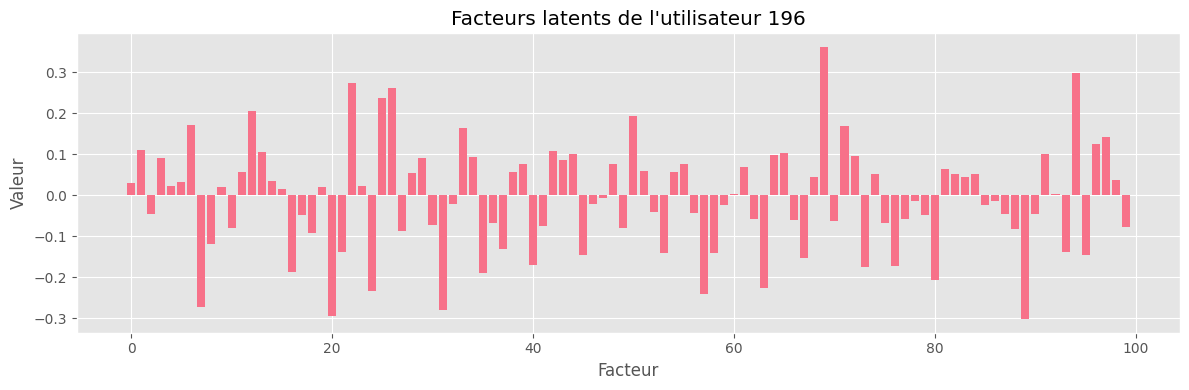

In [20]:
# Récupérer les facteurs latents de l'utilisateur 196
user_factors = algo.pu[trainset.to_inner_uid(user_id)]

print(f"Facteurs latents de l'utilisateur {user_id} :")
print(f"Nombre de facteurs : {len(user_factors)}")
print(f"\nPremiers 10 facteurs :")
print(user_factors[:10])

# Visualiser les facteurs
plt.figure(figsize=(12, 4))
plt.bar(range(len(user_factors)), user_factors)
plt.title(f"Facteurs latents de l'utilisateur {user_id}")
plt.xlabel("Facteur")
plt.ylabel("Valeur")
plt.tight_layout()
plt.show()

Facteurs latents du film 'Get Shorty (1995)' :

Premiers 10 facteurs :
[ 0.1197976  -0.0893007  -0.04954617  0.06817529 -0.18294629 -0.17378989
  0.00855862  0.06480128  0.04259184  0.02434061]


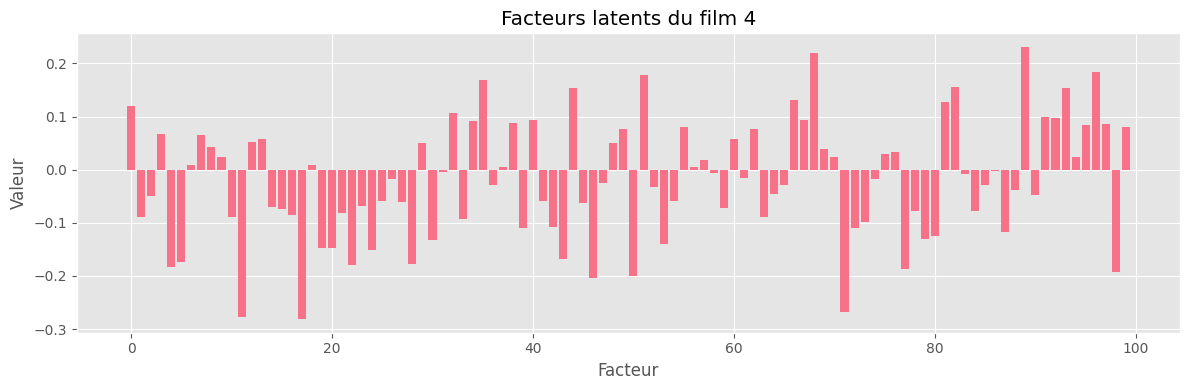

In [21]:
# Choisir un film que l'utilisateur a aimé
movie_id = 4  # Stand by Me

# Récupérer les facteurs du film
movie_factors = algo.qi[trainset.to_inner_iid(movie_id)]

print(f"Facteurs latents du film '{movies[movies['item_id'] == movie_id]['title'].values[0]}' :")
print(f"\nPremiers 10 facteurs :")
print(movie_factors[:10])

# Visualiser les facteurs
plt.figure(figsize=(12, 4))
plt.bar(range(len(movie_factors)), movie_factors)
plt.title(f"Facteurs latents du film {movie_id}")
plt.xlabel("Facteur")
plt.ylabel("Valeur")
plt.tight_layout()
plt.show()

In [22]:
# Calculer la similarité (produit scalaire) entre l'utilisateur et le film
similarity = np.dot(user_factors, movie_factors)

print(f"Similarité entre l'utilisateur {user_id} et le film {movie_id} : {similarity:.4f}")
print("\nInterprétation :")
print("Plus cette valeur est élevée, plus l'utilisateur devrait aimer le film")

# Récupérer la note réelle si l'utilisateur a noté ce film
user_rating = ratings[(ratings['user_id'] == user_id) & (ratings['item_id'] == movie_id)]

if len(user_rating) > 0:
    print(f"Note réelle donnée par l'utilisateur : {user_rating['rating'].values[0]}")
else:
    print("L'utilisateur n'a pas encore noté ce film")
    
# Prédire la note avec le modèle
pred = algo.predict(user_id, movie_id)
print(f"Note prédite par le modèle : {pred.est:.2f}")

Similarité entre l'utilisateur 196 et le film 4 : -0.0611

Interprétation :
Plus cette valeur est élevée, plus l'utilisateur devrait aimer le film
L'utilisateur n'a pas encore noté ce film
Note prédite par le modèle : 4.59


## 8. Sauvegarde du Modèle et Résumé

Nous sauvegardons le modèle entraîné pour pouvoir l'utiliser dans les prochains notebooks sans avoir à le réentraîner.

In [23]:
import pickle
import os

os.makedirs('../models' , exist_ok=True)
model_path = '../models/svd_model.pkl'

with open(model_path , 'wb') as f:
    pickle.dump(algo , f)

print(f"Modèle sauvegardé dans : {model_path}")

Modèle sauvegardé dans : ../models/svd_model.pkl


## Résumé du Notebook 2

### Ce qu'on a appris :

1. Le Collaborative Filtering utilise les comportements des utilisateurs pour faire des recommandations
2. SVD décompose la matrice utilisateur-film en facteurs latents (dimensions cachées)
3. Le modèle apprend 100 facteurs pour représenter les préférences

### Résultats obtenus :

- RMSE : environ 0.93 (erreur moyenne de prédiction)
- MAE : environ 0.74
- Le modèle peut recommander des films pertinents pour chaque utilisateur

### Prochaine étape :

Dans le Notebook 3, nous allons implémenter le Content-Based Filtering qui utilise les métadonnées des films (genres, titres) au lieu des notes.

In [24]:
movies.columns

Index(['item_id', 'title', 'clean_title', 'year', 'genres', 'unknown',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [25]:
# Fonction rapide pour tester avec différents utilisateurs
def show_recommendations_for_user(user_id, n=5):
    """
    Affiche l'historique et les recommandations pour un utilisateur
    """
    # Historique
    user_hist = ratings[ratings['user_id'] == user_id].merge(
        movies[['item_id', 'title' , 'genres']], 
        on='item_id'
    ).sort_values('rating', ascending=False)
    
    print(f"=== UTILISATEUR {user_id} ===\n")
    print(f"Nombre de films notés : {len(user_hist)}\n")
    print("Top films aimés :")
    print(user_hist[['title', 'rating' , 'genres']].head(3))
    
    # Recommandations
    recs = get_top_n_recommendations(algo, user_id, ratings, movies, n)
    print(f"\nTop {n} recommandations :")
    print(recs[['title', 'predicted_rating','genres']].to_string(index=False))
    print("\n" + "="*60 + "\n")

# Tester avec 3 utilisateurs différents
for uid in [50, 150, 300]:
    show_recommendations_for_user(uid, n=5)

=== UTILISATEUR 50 ===

Nombre de films notés : 24

Top films aimés :
                              title  rating                  genres
12  Everyone Says I Love You (1996)       5  Comedy|Musical|Romance
15        I Shot Andy Warhol (1996)       5                   Drama
2           Pillow Book, The (1995)       5           Drama|Romance

Top 5 recommandations :
                             title  predicted_rating                     genres
                  Toy Story (1995)               5.0  Animation|Children|Comedy
               Shining, The (1980)               5.0                     Horror
Around the World in 80 Days (1956)               5.0           Adventure|Comedy
                  Notorious (1946)               5.0 Film-Noir|Romance|Thriller
                    Matilda (1996)               5.0            Children|Comedy


=== UTILISATEUR 150 ===

Nombre de films notés : 32

Top films aimés :
                        title  rating                               genres
1   R